# Sinaloa Shrimp production

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from openpyxl import load_workbook
import numpy as np
import geopandas as gpd
from matplotlib.gridspec import GridSpec


### Extract culture and harvest data 

Read a '.xlsx' file with several related tables 

In [2]:
file = '''producción_Sinaloa.xlsx''' # File name

# Create a list containing excel sheet names

sheet_name = load_workbook ( file , read_only= True ).sheetnames 

# Create a dictionary with sheet name (key) and related table (value) 

dfs = { i : pd.read_excel ( file , sheet_name = i )  for i in sheet_name  }

# Eliminate useless columns

dfs [ 'fecha de actualización' ] = dfs [ 'fecha de actualización' ] [ ['Folio' , 'Fecha de actualización'] ].dropna()


Set the date for each table for further time analysis

In [3]:
# Creates a loop merging all the tables with the dates table ('fecha de actualización') 

for i in range ( len ( sheet_name ) ) [ : -1 ] : #Avoid last element corresponding to dates table

    # merge tables with de ID called 'folio' and drop useless columns

    m = dfs [ sheet_name [ i ] ].merge ( dfs [ sheet_name [ -1 ] ] , 
                                        left_on= 'folio_fecha' , right_on = 'Folio' 
                                        ).drop ( columns = [ 'folio' , 'Folio' , ] ) 

    # Set the date column in the first place of the table

    m = m [ [ m.columns.to_list () [ -1] ] +  ( m.columns.to_list () [ : -1] ) ]

    # Override tables in dicts dfs with the new column

    dfs [ sheet_name [ i ] ] = m

Create objects for each Data Frame from dfs

In [4]:
semi_siembra = dfs [ 'semi-intensivo']

semi_cosecha = dfs [ 'semi-intensivo-cosecha' ]

hiper_siembra = dfs [ 'hiper_intensivo' ]

hiper_cosecha = dfs [ 'hiper_intensivo_cosecha' ]

### Sinaloa geometric data

In [5]:
# Define the file name (included in this repository) to create map plotting
pth = "25mun.shx"

#Use geopandas to create the data frame
tracts = gpd.GeoDataFrame.from_file(pth)

# Sort values from colum 'CVE_MUN'
tracts = tracts.sort_values ( 'CVE_MUN')

# Add column 'jsla' for further merging with the others Data Faames

tracts [ 'jsla' ] = [ 'ahome' , 'angostura' , 'badiraguato' , 'concordia' , 'cosala' , 'culiacán' , 'choix' , 'elota' , 
                     'escuinapa' , 'el fuerte' , 'guasave' , 'mzt-san ignacio' , 'mocorito' , 'rosario' , 'salvador alvarado' ,
                      'mzt-san ignaco' , 'sinaloa' , 'navolato' ]

#Show table head to verify the information from tracts
tracts.head(3)

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,jsla
17,25001,25,001,Ahome,"POLYGON ((1804382.444 1610962.613, 1804402.434...",ahome
15,25002,25,002,Angostura,"MULTIPOLYGON (((1861565.220 1471194.549, 18615...",angostura
3,25003,25,003,Badiraguato,"POLYGON ((1959299.447 1575330.583, 1960926.416...",badiraguato


### Prepare the raw data for plotting

Create a general table containing total cultured hectareas and shrimp farms number

In [6]:
# Select needed columns

ha_sembradas = semi_siembra [ [ 'ciclo' , 'hectareas_sembradas_periodo' , 
                               'granjas_sembradas_preriodo'  ] ].groupby ( 'ciclo' ).sum().reset_index()

# Change dtype from column 'ciclo' to str

ha_sembradas ['ciclo'] = ha_sembradas ['ciclo'].astype ( 'str' )

# Create a fourth row with total values

ha_sembradas.loc[ 3 ] = ['total' , ha_sembradas [ 'hectareas_sembradas_periodo'].sum()  
                       , ha_sembradas [ 'granjas_sembradas_preriodo'].sum() ]

# Create a column containing the hectareas percentage respective to the total.

ha_sembradas ['porcentaje'] = ha_sembradas [ 'hectareas_sembradas_periodo' ] / ha_sembradas[ 'hectareas_sembradas_periodo'].iloc [ 3 ] * 100

# Obtain hectareas perecentage respective to the firs cicle of culture of the year

ha_sembradas ['porcentaje_primer_ciclo'] = ha_sembradas [ 'hectareas_sembradas_periodo' ] / ha_sembradas['hectareas_sembradas_periodo'].iloc [ 0 ]*100

# Round values and show info

ha_sembradas ['hectareas_sembradas_periodo'] = ha_sembradas ['hectareas_sembradas_periodo'].round ( 0 )

for i in [ 'porcentaje' , 'porcentaje_primer_ciclo' ] :

    ha_sembradas [ i ] = ha_sembradas [ i ].round (2)

ha_sembradas

,ciclo,hectareas_sembradas_periodo,granjas_sembradas_preriodo,porcentaje,porcentaje_primer_ciclo
0,1,53437.0,853,61.99,100.00
1,2,32085.0,586,37.22,60.04
2,3,683.0,40,0.79,1.28
3,total,86205.0,1479,100.00,161.32


Aggrupate values of hectareas and farms by cicle and region

In [34]:
# Sum the values by cicle and region

ha_sembradas_2 = semi_siembra [ [ 'jsla' ,  'hectareas_sembradas_periodo' , 'ciclo' , 'granjas_sembradas_preriodo' , 'densidad' ] 
                               ].groupby ( [ 'ciclo' , 'jsla' ] ).sum().reset_index()

# Change cicle dtype to str

ha_sembradas_2 ['ciclo'] = ha_sembradas_2 ['ciclo'].astype ( 'str' )

# Sort values

ha_sembradas_2.sort_values ( 'jsla' ).reset_index( drop = True) 

# Obtain percentage of area for each region. It takes the value from the first cicle to establis the amount of physical hectarias.

ha_sembradas_2 [ 'porcentaje_total_primer_ciclo'] = ha_sembradas_2 [ 'hectareas_sembradas_periodo'] / ha_sembradas['hectareas_sembradas_periodo'].iloc [ 0 ] * 100

# Proportion for sencond and third cccle

## Merge  and divide with first cicle values to obtain the porcentage

primer_ciclo = ha_sembradas_2.query(''' ciclo == '1' ''') [ [ 'jsla' , 'hectareas_sembradas_periodo' ] ].rename ( columns = { 'hectareas_sembradas_periodo' : 'ha' })

ha_sembradas_2 = ha_sembradas_2.merge ( primer_ciclo , right_on= 'jsla' , left_on = 'jsla' ).reset_index ( drop = True )

ha_sembradas_2 [ 'procentaje_resp_primer_ciclo_reg'] = ha_sembradas_2 [ 'hectareas_sembradas_periodo'] / ha_sembradas_2 [ 'ha' ] *100

# Drop useless columns and show info

ha_sembradas_2 = ha_sembradas_2.drop ( columns = ['ha'] )

ha_sembradas_2 [ 'hectareas_sembradas_periodo' ] = ha_sembradas_2 [ 'hectareas_sembradas_periodo'].round(0)

ha_sembradas_2 [ 'porcentaje_total_primer_ciclo' ] = ha_sembradas_2 [ 'porcentaje_total_primer_ciclo'].round(0)

ha_sembradas_2 [ 'procentaje_resp_primer_ciclo_reg' ] = ha_sembradas_2 [ 'procentaje_resp_primer_ciclo_reg' ].round(0)

ha_sembradas_2.head ( 5 )

,ciclo,jsla,hectareas_sembradas_periodo,granjas_sembradas_preriodo,densidad,porcentaje_total_primer_ciclo,procentaje_resp_primer_ciclo_reg
0,1,ahome,11844.0,96,364,22.0,100.0
1,2,ahome,3700.0,36,96,7.0,31.0
2,1,angostura,6659.0,86,319,12.0,100.0
3,2,angostura,5522.0,70,181,10.0,83.0
4,1,culiacán,8852.0,324,578,17.0,100.0


#### Plots

Create functions for formating and graphic complements.

In [ ]:
def fc(x):
    """
    Integers format
    """
    return f"{x:,}"

def info_bars ( fig , fontsi = False , some_arg = False , weight = False ) : 
     
    ''' 
    Obtain the horizontal bar values to insert them as labels 

    fig : object, figure to insert the values
    fontsi = int, Fontsize
    some_arg : str, Symbol to add to the label
    Weight : boolean, to decide to set bold format to labels
    '''
    if weight ==  True : 

        weight = 'bold'
     
    if some_arg == False :
        
        some_arg = ''

    # Obtain values from container
    for c in fig.containers :

        labels = [ f'{int(w)} {some_arg}' if (w := v.get_width()) > 0 else '' for v in c ]
        
        # Insert label

        fig.bar_label (c, labels=labels, label_type='edge' , padding= 10 , fontsize = fontsi , weight = weight )


def info_bars_v ( figure , n_space , fontsi = False , some_arg = False , x = False , weight = False ) : 
    ''' 
    Obtain the vertical bar values to insert them as labels 

    figure : object, figure to insert the values
    n_space : int, distance desired between the bar and the label
    fontsi = int, Fontsize
    some_arg : str, Symbol to add to the label
    x : int, distance desired between the x value from the bar and the label
    Weight : boolean, to decide to set bold format to labels
    '''

    #Default x value
    if x == False :
        x = 1.0005

    # Empty space for some_arg if it is not needed

    if some_arg == False:
    
        some_arg = ''

    # Obtain x value from container

    for p in figure.patches :

        if p.get_height() != 0 :
        
            figure.annotate  ( str ( fc (int ( np.around( p.get_height() ) ) ) ) + some_arg , ( p.get_x() + x  ,  p.get_height() + n_space ) , 
                              fontsize = fontsi , horizontalalignment = 'center' , weight = weight  )
            


def info_bars_op ( figure , figure_2 , n_space , fontsi = False , some_arg = False , x = False , weight = False ) : 
    
    ''' 
    Obtain secundary values from the figure to insert them as label

    figure : object, Figure to insert the labels
    figure_2 : object, Figure with the values to obtain
    n_space : int, Distance between y value and the label
    fontsi = int, Fontsize
    some_arg : str, Symbol to add to the label
    x : int, distance desired between the x value from the bar and the label
    Weight : boolean, to decide to set bold format to labels
    '''

    #Default x value
    if x == False :
        x = 1.0005

    #Emptu space if some_arg is not needed

    if some_arg == False:
    
        some_arg = ''

    # Obtain values from figure_" and insert them in figure

    for p,q in zip (figure_2.patches , figure.patches ) :

        if p.get_height() != 0 :
        
                    figure.annotate  ( str ( fc (int ( np.around( p.get_height() ) ) ) ) + some_arg , ( p.get_x() + x ,  q.get_height() + n_space ) ,
                                       fontsize = fontsi , horizontalalignment = 'center' , weight = weight , color = 'steelblue' )


def truncate (x):

    '''
    Truncate numbers
    '''

    return np.truncate ( x , 0)

##### General information figure

In [33]:
#Copy table to avoid modifications and drop unnecessary columns
cosecha = semi_cosecha.copy ( ) [ [ 'Fecha de actualización' , 'jsla' , 'ciclo' , 'granjas_cosechadas_periodo' , 'fca' , 'kg_ha' , 'peso' , 'sobrevivencia' ] ]

df2 = ha_sembradas_2.copy().drop ( columns = [ 'densidad' ] )

# Culture proportion of each region

prop = df2 [ [ 'ciclo' , 'jsla' , 'porcentaje_total_primer_ciclo' ] ].query ( ''' ciclo  ==  '1' ''').set_index ( 'jsla' ).drop ( columns= ( 'ciclo' ) ).sort_values ( 'porcentaje_total_primer_ciclo')

# Merge with geometric data, filling blank values with 0. Round values

plog = tracts.join ( prop , 'jsla' ).fillna (0) 

plog [ 'porcentaje_total_primer_ciclo' ] = plog [ 'porcentaje_total_primer_ciclo' ].round(1)

# Insert coords column with the crentroid to further insertion for the region name in the map.

plog[ 'coords' ] = plog['geometry'].apply(lambda x: x.centroid.coords[:])

plog['coords'] = [coords[0] for coords in plog['coords']]

Generate the values and strings to set as writen information

In [36]:
# Farms cicle 1
granjas_ciclo1 = ha_sembradas.query ( '''ciclo == '1' ''' ) [ 'granjas_sembradas_preriodo'] [ 0 ]

# Farms cicle 2
granjas_ciclo2 = ha_sembradas.query ( '''ciclo == '2' ''' ) [ 'granjas_sembradas_preriodo'] [ 1 ]

# Farms cicle 3
granjas_ciclo3 = ha_sembradas.query ( '''ciclo == '3' ''' ) [ 'granjas_sembradas_preriodo'] [ 2 ]

# Hectareas cicle 1
ha_ciclo1 = ha_sembradas.query ( '''ciclo == '1' ''' ) [ 'hectareas_sembradas_periodo'] [ 0 ]

# Hectareas cicle 2
ha_ciclo2 = ha_sembradas.query ( '''ciclo == '2' ''' ) [ 'hectareas_sembradas_periodo'] [ 1 ]

# Hectareas cicle 3
ha_ciclo3 = ha_sembradas.query ( '''ciclo == '3' ''' ) [ 'hectareas_sembradas_periodo'] [ 2 ]

# Total hectareas
ha_ciclot = ha_sembradas.query ( '''ciclo == 'total' ''' ) [ 'hectareas_sembradas_periodo'] [ 3 ]

# Informative string
txt_intro = f'''
    Se sembraron {granjas_ciclo1} granjas en Sinaloa el 2023,
    {granjas_ciclo2} realizaron el segundo ciclo y 
    {granjas_ciclo3} el tercero
    '''
# Table with percentage of each region
info_table = plog [ [ 'NOMGEO' , 'porcentaje_total_primer_ciclo' ] ].query ( ''' porcentaje_total_primer_ciclo  > 0 ''' ).sort_values ( 'porcentaje_total_primer_ciclo' , ascending = False )
info_table [ 'porcentaje_total_primer_ciclo' ] = info_table [ 'porcentaje_total_primer_ciclo' ].astype (str) + '%'

Pallete for plots

In [10]:
pallete = sns.color_palette ('Blues')

pallete_2 = sns.color_palette ( 'Blues_r' )

pallete_3 = sns.color_palette ( 'GnBu' )

pallete_4 = sns.color_palette ( 'BuPu' )

color_numbers = '#151B8D'

__Creating first plot__

Plot with Sinaloa's general production info 

(1684986.287221629, 2583425.2531212247)

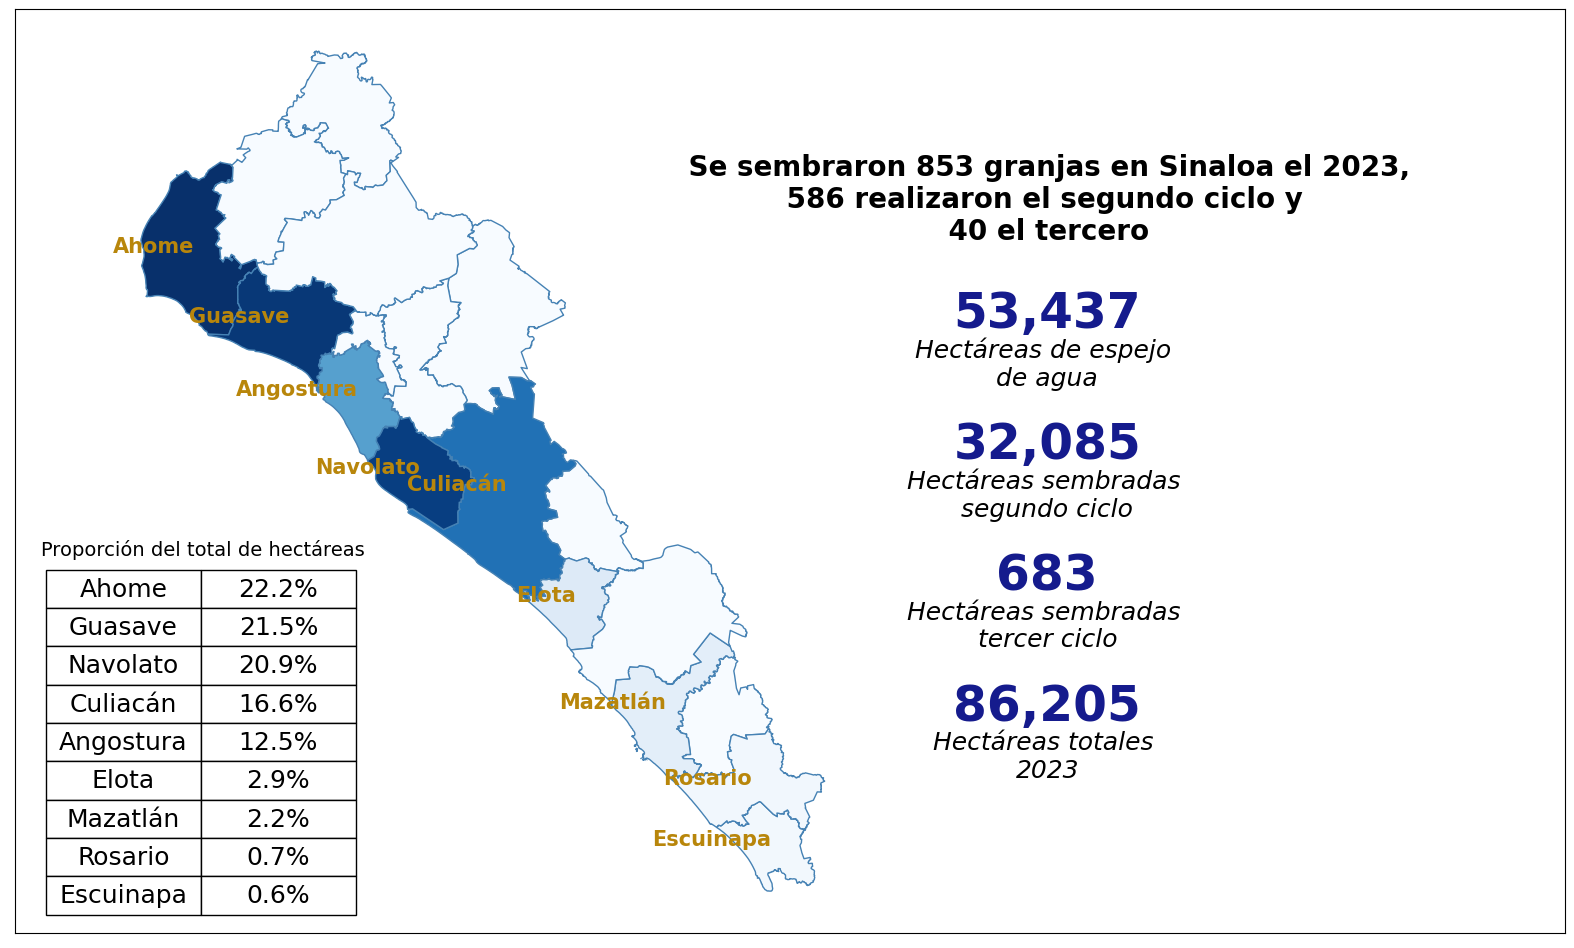

In [38]:
figure , axes = plt.subplots (  1 , 1 , figsize = ( 20 , 12 ) )

# Sinaloa map plot
map = plog.plot('porcentaje_total_primer_ciclo', edgecolor = 'steelblue',  cmap = 'Blues',  ax = axes   )

# Insert names of each region
for idx , row in  plog.iterrows () :

    if row [ 'porcentaje_total_primer_ciclo' ] != 0 :

        name = row [ 'NOMGEO'] 
        map.annotate ( name ,
                        row [ 'coords' ]  , 
                        horizontalalignment='right', 
                        color = 'darkgoldenrod' , 
                        weight = 'bold', 
                        fontsize = 15
                        )
# Eliminate axis for better visualization
map.get_xaxis().set_visible(False)
map.get_yaxis().set_visible(False)

# Text intro
map.annotate ( txt_intro , ( 2273425.2531212247, 1543986.287221629 ) ,  horizontalalignment = 'center' , fontsize = 20 , weight = 'bold' )

# Values and tex for cultured hectaras per cicle
## Cicle 1
### Value 
map.annotate ( str ( fc(int ( ha_ciclo1 ))  ) , ( 2283425.2531212247, 1509986.287221629 ) , 
              horizontalalignment = 'center', fontsize = 35 , color = color_numbers , weight = 'bold'  )

### Text
map.annotate ( 'Hectáreas de espejo \nde agua' , ( 2283425.2531212247, 1474986.287221629 ) , horizontalalignment = 'center' , fontsize = 18 , style = 'italic' )

## Cicle 2
### Value
map.annotate ( str ( (fc (int ( ha_ciclo2 ) ) ) ) , ( 2283425.2531212247, 1429986.287221629 ) , 
              horizontalalignment = 'center', fontsize = 35 , color = color_numbers , weight = 'bold'  )

### Text
map.annotate ( 'Hectáreas sembradas \nsegundo ciclo' , ( 2283425.2531212247, 1394986.287221629 ) , horizontalalignment = 'center' , fontsize = 18 , style = 'italic' )

## Cicle 3
### Value
map.annotate ( str ( fc ( int ( ha_ciclo3 ) ) ) , ( 2283425.2531212247, 1349986.287221629 ) , 
              horizontalalignment = 'center', fontsize = 35 , color = color_numbers , weight = 'bold'  )

### Text
map.annotate ( 'Hectáreas sembradas \ntercer ciclo' , ( 2283425.2531212247, 1314986.287221629 ) , horizontalalignment = 'center' , fontsize = 18 , style = 'italic' )

## Total hectareas

### Value
map.annotate ( str ( fc ( int ( ha_ciclot  ) ) ) , ( 2283425.2531212247, 1269986.287221629 ) , 
              horizontalalignment = 'center', fontsize = 35 , color = color_numbers , weight = 'bold'  )

### Text
map.annotate ( 'Hectáreas totales \n2023' , ( 2283425.2531212247, 1234986.287221629 ) , horizontalalignment = 'center' , fontsize = 18 , style = 'italic' )


# Table

## Table title
map.annotate ( 'Proporción del total de hectáreas' , ( 1793821.8624098692 , 1370854.0398249433 ) , horizontalalignment = 'center' , fontsize = 14 )

## Creating table
table = axes.table ( cellText = info_table.values , loc = 'lower left' , cellLoc='center' ) #, rowColours =  )

## table format
table.scale ( .2, 2.3 )
table.set_fontsize ( 20 )
axes.axis('tight')


# Plot centering
axes.set_xlim ( 1684986.287221629 , 2583425.2531212247 )

##### Culture per region figure

In [14]:
# Set the data

# Cultures Hectareas per cicle
# Pivot table to plot the data

ciclo  = df2[ ['ciclo' , 'jsla' , 'hectareas_sembradas_periodo' ] ].set_index ('jsla' ).pivot(columns=( 'ciclo' ))  

ciclo [ 'Total' ] = ciclo.sum ( axis= 1)

#Compare each cicle per region

ciclo = ciclo [[ ( 'Total',  '')  , ('hectareas_sembradas_periodo', '3') , ('hectareas_sembradas_periodo', '2') , ('hectareas_sembradas_periodo', '1')   ]].sort_values ( (                       'Total',  '' )  , ascending= True )

ciclo [ 'Ciclo 2 vs Ciclo 1'   ] = ciclo [ ('hectareas_sembradas_periodo', '2') ] / ciclo [ ('hectareas_sembradas_periodo', '1') ] * 100

ciclo [ 'Ciclo 3 vs Ciclo 2' ] = ciclo [ ('hectareas_sembradas_periodo', '3') ] / ciclo [ ('hectareas_sembradas_periodo', '2') ] * 100

#Rename index for better presentation

ciclo = ciclo.rename ( index= { 'escuinapa' : 'Escuinapa' , 'rosario' : 'Rosario' , 'mzt-san ignacio' : 'Mzt-SI' , 'elota' : 'Elota' , 'angostura' : 'Angostura' ,
                     'ahome' : 'Ahome' , 'culiacán' : 'Culiacán' , 'guasave' : 'Guasave' , 'navolato' : 'Navolato'
                       })

# Divided in two tables to diversify info (Fig 2 plot df)

fig_2_df = ciclo [ [ 'Ciclo 3 vs Ciclo 2' , 'Ciclo 2 vs Ciclo 1'   ] ].query ( '''index in ( 'Guasave' , 'Ahome' , 'Navolato' , 'Culiacán' , 'Angostura' ) ''' ).sort_values ( 'Ciclo 2 vs Ciclo 1' ).fillna(0)

fig_2a_df = ciclo [ [ 'Ciclo 3 vs Ciclo 2' , 'Ciclo 2 vs Ciclo 1'  ] ].query ( '''index not in ( 'Guasave' , 'Ahome' , 'Navolato' , 'Culiacán' , 'Angostura' ) ''' ).sort_values ( 'Ciclo 2 vs Ciclo 1' ).fillna(0)



Text(110, 3, 'C)')

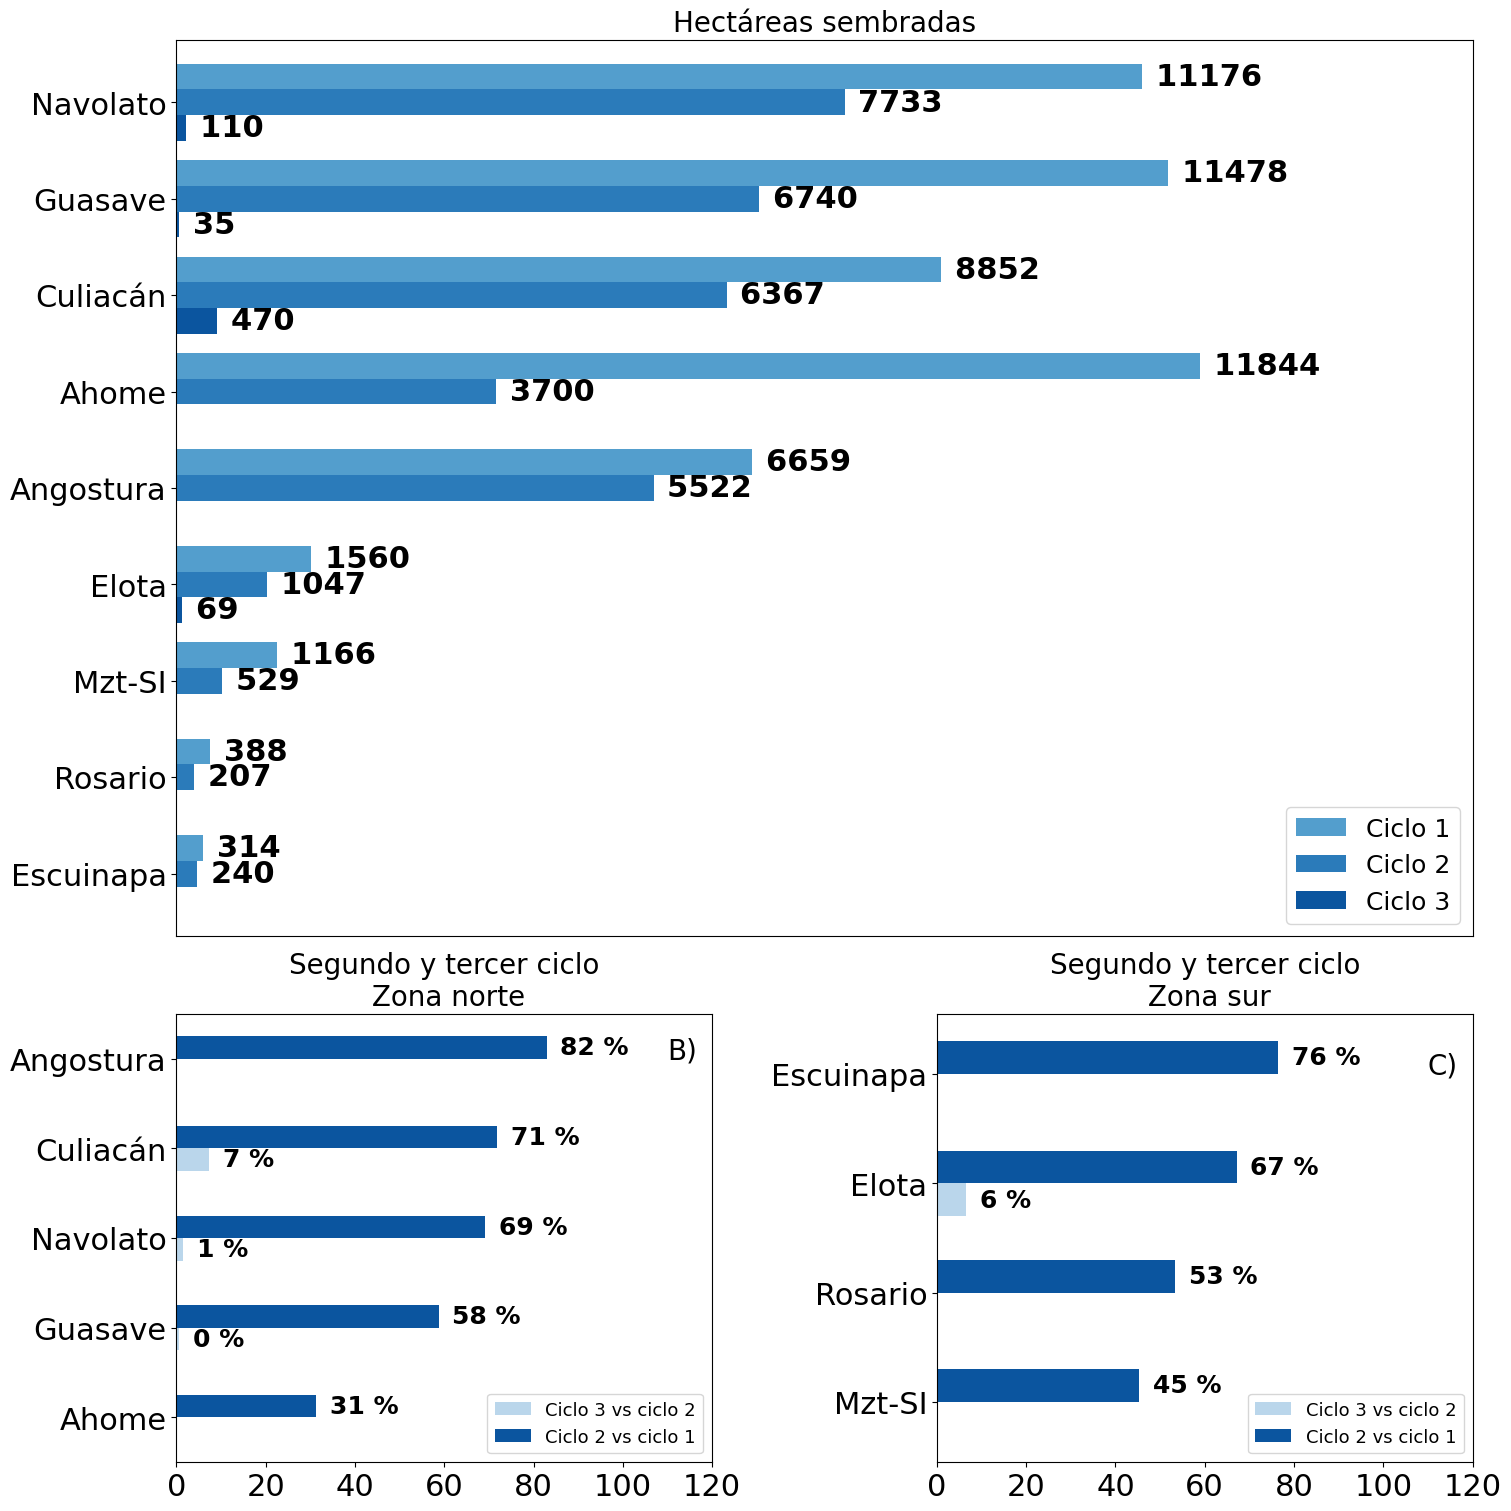

In [29]:
#Define the figure and it's grid to insert multiple plots

figure_5 = plt.figure ( layout="constrained" , figsize= ( 15 , 15) )
gs = GridSpec ( 3 , 2 , figure = figure_5   )

#Insert plots in each grid
ax1 = figure_5.add_subplot(gs[0:2, : ])
ax2 = figure_5.add_subplot(gs[2, :-1])
ax3 = figure_5.add_subplot(gs[2:, -1])

#First figure
##Plot using pandas plot and insert to ax1
fig = ciclo.drop ( columns = [ ('Total',  '') , ('Ciclo 2 vs Ciclo 1',  ''), ('Ciclo 3 vs Ciclo 2',  '')] ).plot.barh ( color= pallete_2  , stacked = False , xlabel = '' ,
                                                                                                                         fontsize = 22 , ax = ax1 , width = 0.8 )
ax1.set_title ( 'Hectáreas sembradas' )
ax1.title.set_size (20)

##Give format 
info_bars (fig, fontsi = 22 , weight = 'bold' )
fig.set_xlim ( 0, 15000)
fig.get_xaxis().set_visible(False)

##Change order of labels
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], ['Ciclo 1' , 'Ciclo 2' , 'Ciclo 3' ], loc = 'lower right' , title = False , fontsize = 18 )

#Second figure
fig_2 = fig_2_df.plot.barh ( ax = ax2 , color =  pallete [ 1:2 ] + [pallete_2 [0]] ,  fontsize = 22 , xlabel = '', width = 0.5 )
ax2.set_title ( 'Segundo y tercer ciclo\n Zona norte' )
ax2.title.set_size (20)
info_bars (fig_2 , fontsi = 18 , some_arg = '%' , weight = 'bold' )
fig_2.legend ( [ 'Ciclo 3 vs ciclo 2' , 'Ciclo 2 vs ciclo 1' ] ,  title = False , loc = 'lower right' , fontsize = 13 )
fig_2.set_xlim ( 0 , 120 )

#Third figure
fig_2a = fig_2a_df.plot.barh ( ax = ax3 , color = pallete [ 1:2 ] + [pallete_2 [0]] , title = 'Zona centro/sur' , fontsize = 22 , xlabel = '' , width = 0.6 )
ax3.set_title ( 'Segundo y tercer ciclo\n Zona sur' )
ax3.title.set_size (20)
info_bars (fig_2a , fontsi = 18 , some_arg = '%' , weight = 'bold' )
fig_2a.legend ( [ 'Ciclo 3 vs ciclo 2' , 'Ciclo 2 vs ciclo 1' ] ,  title = False , loc = 'lower right' , fontsize = 13 )
fig_2a.set_xlim ( 0 , 120 )

#Figures Index
ax1.annotate ( 'A)' , ( 22000 , 8.1 ) , fontsize = 20 )
ax2.annotate ( 'B)' , ( 110 , 4 ) , fontsize = 20 )
ax3.annotate ( 'C)' , ( 110 , 3 ) , fontsize = 20 )

Production time line

In [17]:
#Prepare the needed data
time_line = semi_siembra [ [ 'Fecha de actualización' , 'jsla' , 'ciclo' , 'hectareas_sembradas_periodo' , 'granjas_sembradas_preriodo' , 'densidad' ] ]

time_line [ 'mes' ] = pd.DatetimeIndex ( semi_siembra [ 'Fecha de actualización'] ).month

time_line

C:\Users\aldou\AppData\Local\Temp\ipykernel_20552\2190830121.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_line [ 'mes' ] = pd.DatetimeIndex ( semi_siembra [ 'Fecha de actualización'] ).month


,Fecha de actualización,jsla,ciclo,hectareas_sembradas_periodo,granjas_sembradas_preriodo,densidad,mes
0,2023-03-15 00:00:00,guasave,1,442.32,7,11,3
1,2023-03-15 00:00:00,guasave,1,595.10,6,10,3
2,2023-03-15 00:00:00,angostura,1,3196.46,38,11,3
3,2023-03-15 00:00:00,navolato,1,2058.30,25,10,3
4,2023-03-15 00:00:00,navolato,1,2571.72,31,11,3
...,...,...,...,...,...,...,...
539,2023-11-08 00:00:00,guasave,3,0.00,0,10,11
540,2023-11-08 00:00:00,navolato,3,0.00,0,8,11
541,2023-11-08 00:00:00,culiacán,3,0.00,0,8,11
542,2023-11-08 00:00:00,culiacán,3,5.00,1,7,11


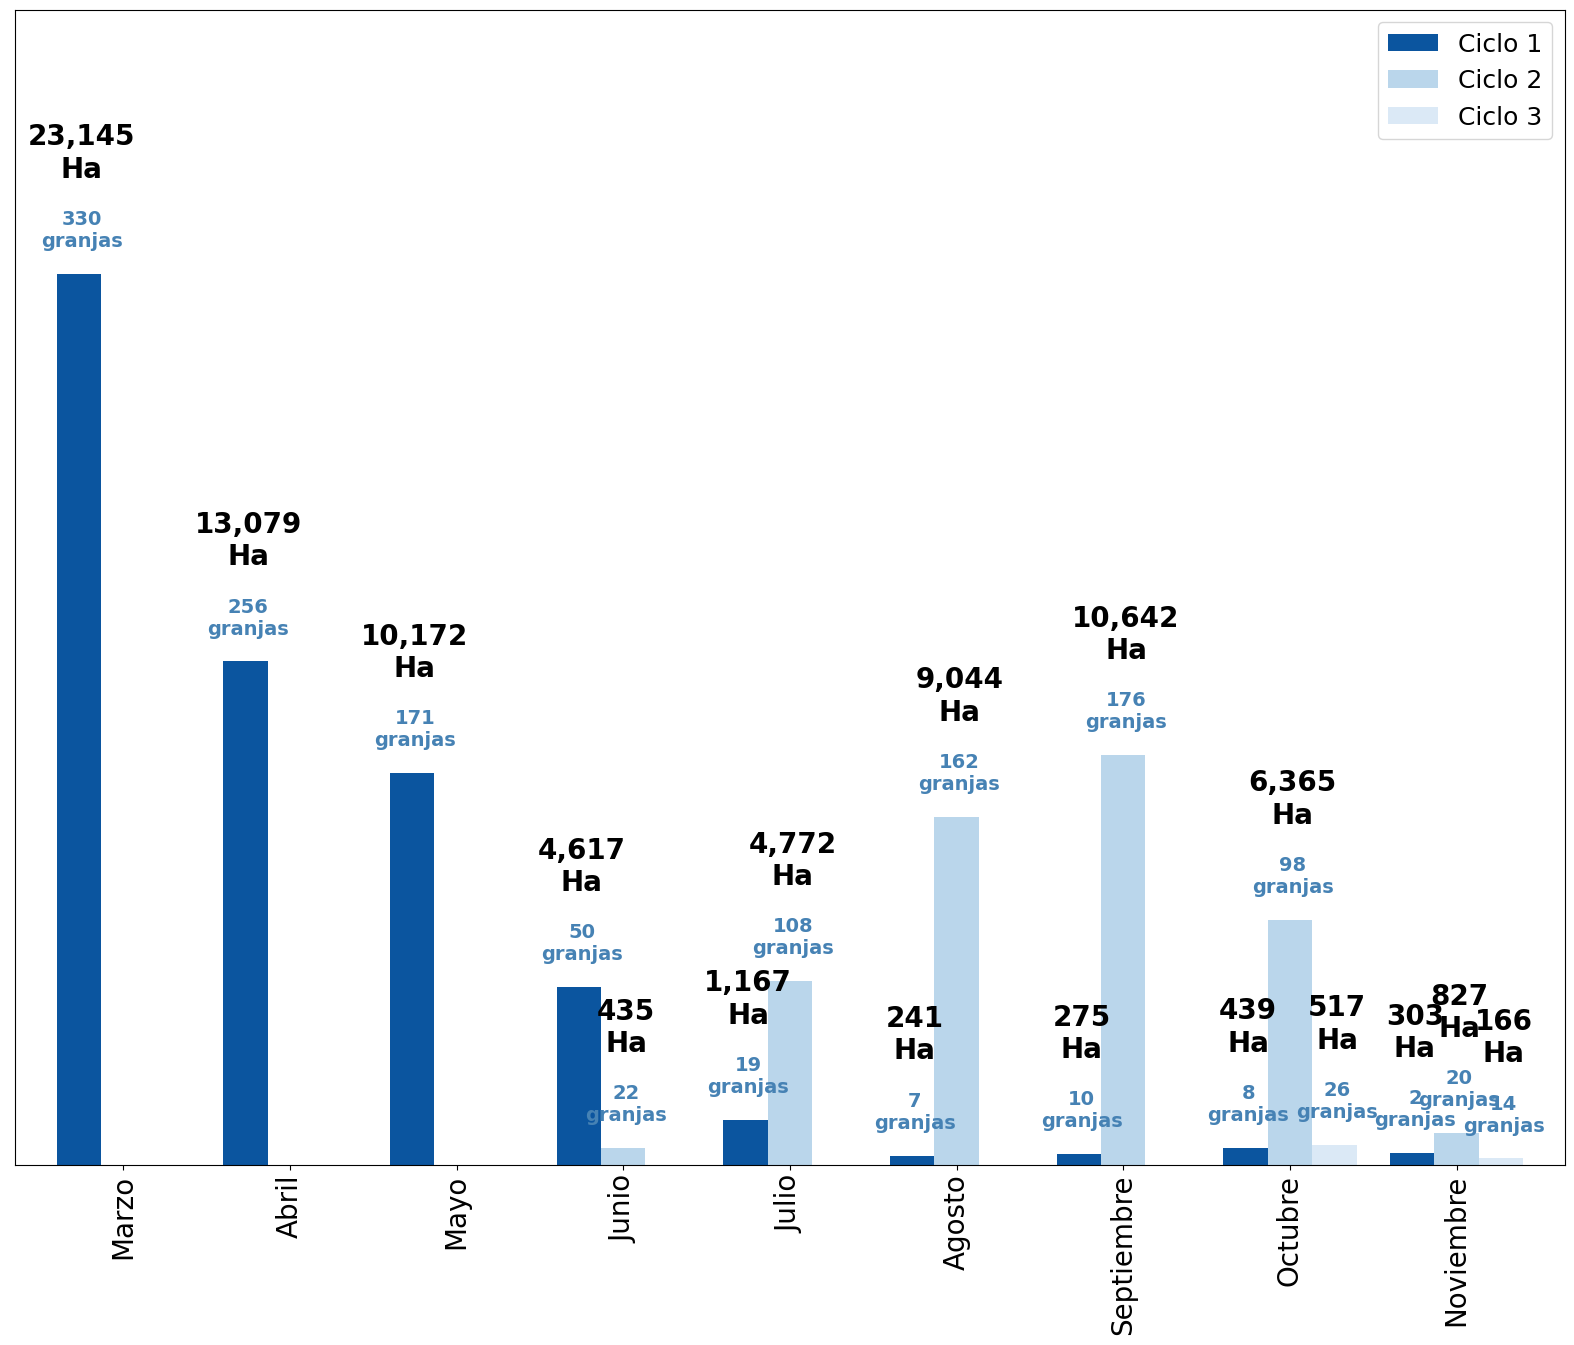

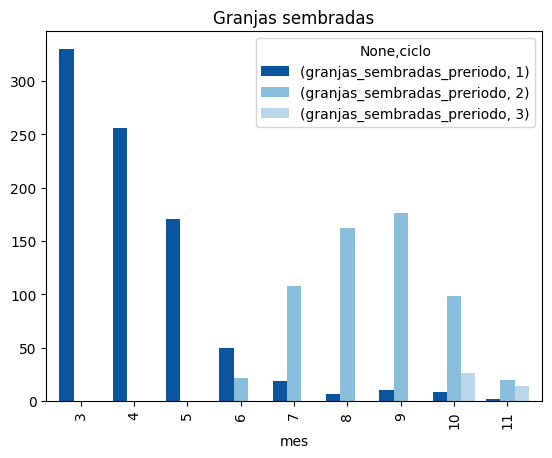

In [18]:
#Group data by month
siembra_mensual = time_line.groupby ( [ 'mes' ,  'ciclo' ] ).sum().reset_index ().set_index ('mes')

#Declare the figure
figure_3 , axes_3 = plt.subplots ( 1 , 1 , figsize = ( 20 , 15 ) )
x = 0.15

#First figure
##Plotting
fig_3 = siembra_mensual [ [ 'ciclo' , 'hectareas_sembradas_periodo' ] ].pivot ( columns = ('ciclo') ).plot.bar ( color= [pallete_2 [0] ] + [pallete [ 1 ] ] + [pallete_2 [ -1 ]] ,
                                                                                                                  ax = axes_3  ,
                                                                                                                  width = .8 , linewidth=1 ,
                                                                                                                  xlabel = '' ,
                                                                                                                  fontsize = 20 ,
                                                                                                                  )
fig_3.legend ( [ 'Ciclo 1' , 'Ciclo 2' , 'Ciclo 3' ] , title = False , fontsize = 18  )
fig_3.set_ylim ( 0 , 30000)
info_bars_v ( fig_3 , 2500 , 20 , some_arg= '\nHa' ,  x = x , weight = 'bold' )
fig_3.set_xticklabels ( ['Marzo' , 'Abril' , 'Mayo' , 'Junio' , 'Julio' , 'Agosto' , 'Septiembre' , 'Octubre' , 'Noviembre' ] )
fig_3.get_yaxis().set_visible(False)

#Second figure
##Plot the second figure to obtain number of farms values and insert them in first figure
fig_3a = siembra_mensual [ [ 'ciclo' , 'granjas_sembradas_preriodo' ] ].pivot ( columns = ('ciclo') ).plot.bar ( color= [pallete_2 [0] ] + [pallete_2 [ 3 ] ] + [pallete_2 [ 4 ]] , 
                                                                                                                title = 'Granjas sembradas',
                                                                                                                  width = .8  , linewidth=1 ) # figsize = ( 12, 8 ) )
info_bars_op ( fig_3 , fig_3a , 700 , 14 , some_arg= '\ngranjas' , x = x , weight = 'bold' )

In [19]:
#Rename months
siembra_mensual.rename ( index = { 3 : 'Marzo' , 4 : 'Abril' , 5 : 'Mayo' , 6 : 'Junio' , 7 : 'Julio' , 8 : 'Agosto' , 9 : 'Septiembre' , 10 : 'Octubre' , 11 : 'Noviembre' } )

,ciclo,hectareas_sembradas_periodo,granjas_sembradas_preriodo,densidad
mes,,,,
Marzo,1,23145.11,330,357
Abril,1,13079.14,256,513
Mayo,1,10171.90,171,388
Junio,1,4616.73,50,524
Junio,2,435.20,22,71
Julio,1,1166.73,19,264
Julio,2,4771.94,108,186
Agosto,1,240.87,7,528
Agosto,2,9043.96,162,505


In [20]:
#Obtain mean hectareas for farm
siembra_mensual [ 'ha_granja' ] = siembra_mensual [ 'hectareas_sembradas_periodo' ] / siembra_mensual [ 'granjas_sembradas_preriodo' ]

siembra_mensual.ha_granja.mean().round(2) , siembra_mensual.ha_granja.std().round(2) , siembra_mensual.ha_granja.max().round(2) , siembra_mensual.ha_granja.min().round(2)

(54.18, 32.55, 151.5, 11.89)

In [21]:
#Group by month, cicle and region
siembra_region = time_line  [ [ 'mes' , 'jsla' , 'ciclo' , 'hectareas_sembradas_periodo' , 'granjas_sembradas_preriodo'  ] ].groupby ( [ 'mes' , 'ciclo' , 'jsla'  ] ).sum().reset_index().set_index ( 'mes' )


Automatize plotting for each region for plot homogenization

Define functions and class

In [22]:
def ob_param_1 ( jsla , parametro ) : 
    '''Obtains the total farms and hectareas for each region
    jsla = str, region name
    parametro = str, colum name of the parameter to obtain data : hectareas-'hectareas_sembradas_periodo'; number of farms:-'granjas_sembradas_periodos
    
    returns = int, number of farms or hectareas of the selected region'''

    return ha_sembradas_2.query ( ''' jsla == '{}' and ciclo == '1' '''.format ( jsla ) )[ parametro ].reset_index ( drop = True ).loc[0]

def map_region ( region ) :
    '''Extracts the coordenates for the selected region
    
    region = str, region name
    
    returns = filtered data frame by region'''
    
    return tracts.query ( ''' NOMGEO == '{}' '''.format ( region ))

def param_cosecha ( jsla , parame  ) :
    '''Generates a string with the mean and sd for the selected parameter
    
    jsla = str, region name
    parame = str, column name of the selected parameter
    
    return = string with parameter's mean and sd for the selected region '''

    return  str ( cosecha.query ( ''' jsla == '{}' and {} != 0 '''.format ( jsla , parame ) ) [ parame ].median().round (2) ) + ' ± ' + 
            str ( cosecha.query ( ''' jsla == '{}' and {} != 0 '''.format ( jsla, parame) )[ parame ].std().round (2) )

class Datos_region :
    '''Generates plots'''

    def __init__ ( self ,  nomgeom , jsla ) : 
        '''Obtain coordenates and parameters to include in the plot
        nomgeom = str, Region name for the coordenates table
        jsla = str, region name from production table'''

        #Name and coordenates
        self.region = jsla

        self.map = map_region ( nomgeom )

        #Parameters
        self.hectáreas =  fc ( int ( ob_param_1 ( jsla , 'hectareas_sembradas_periodo' ) ) )

        self.granjas = str ( int ( ob_param_1 ( jsla , 'granjas_sembradas_preriodo' ) ) )

        self.densidad =  str ( int ( semi_siembra.query ( ''' jsla == '{}' '''.format ( jsla ) ).densidad.mean ( ).round (0) ) ) + ' ± ' + str ( int ( semi_siembra.query ( ''' jsla == '{}' '''.format (jsla) ).densidad.std ( ).round (0) ) )

        self.fca = param_cosecha ( jsla , 'fca' )

        self.kg_ha = param_cosecha ( jsla , 'kg_ha' )

        self.peso = param_cosecha ( jsla , 'peso' )

        self.sobrevivencia = param_cosecha ( jsla , 'sobrevivencia' )

    def plots  ( self ) :

        #Declare figure, grid and axes
        figure_6 = plt.figure ( layout="constrained" , figsize= (12,8)  )
        gs_2 = GridSpec ( 3 , 4 , figure = figure_6   )

        ax_1 = figure_6.add_subplot(gs_2[ :  , : 2  ])
        ax_2 = figure_6.add_subplot(gs_2[ 0 ,  2: ])
        ax_3 = figure_6.add_subplot(gs_2[ 1 : ,  2: ])

        #Next function is for set border invisible
        def sin_bordes ( ax ) :
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.axis('off')

        # No border for ax_1, ax_2
        sin_bordes (ax_1)
        sin_bordes (ax_2)

        #Creates the complete map overwriting the selected region with different color
        tracts.plot ( ax = ax_1 , color = 'white' , edgecolor = '#1569C7' )
        self.map.plot ( ax = ax_1 , color = 'steelblue'  , edgecolor = '#123456' ) 

        #Data for labels spaces
        x1 = 0.2
        x2 = x1 + .33
        x3 = x2 + .3

        y1 = .7
        y2 = y1 - .3
        y3 = y2 - .3

        y4 = y1 + .1
        y5 = y2 + .1
        y6 = y3+.1

        #Labels for each parameter
        color_etiquete = '#1569C7'
        ax_2.annotate ( 'Ha de espejo de agua' , ( x1 , y1  ) ,  horizontalalignment = 'center' , fontsize = 10 , style = 'italic' , color = color_etiquete )
        ax_2.annotate ( 'Granjas sembradas' , ( x2 , y1 ) ,  horizontalalignment = 'center' , fontsize = 10 , style = 'italic' , color = color_etiquete )
        ax_2.annotate ( 'Densidad de siembra' , ( x3 , y1  ) ,  horizontalalignment = 'center' , fontsize = 10 , style = 'italic' , color = color_etiquete )

        ax_2.annotate ( 'kilogramos / hectárea' , ( x1 , y2 ) ,  horizontalalignment = 'center' , fontsize = 10 , style = 'italic' , color = color_etiquete )
        ax_2.annotate ( 'Peso de cosecha' , ( x2 , y2  ) ,  horizontalalignment = 'center' , fontsize = 10 , style = 'italic' , color = color_etiquete )
        ax_2.annotate ( 'FCA' , ( x3 , y2  ) ,  horizontalalignment = 'center' , fontsize = 10 , style = 'italic' , color = color_etiquete )

        ax_2.annotate ( 'Sobrevivencia' , ( x2 , y3 ) ,  horizontalalignment = 'center' , fontsize = 10 , style = 'italic' , color = color_etiquete )

        # Mean and sd for each parameter
        ax_2.annotate ( self.hectáreas , ( x1 , y4 ) ,  horizontalalignment = 'center' , fontsize = 16 , weight = 'bold' )
        ax_2.annotate ( self.granjas , ( x2 , y4  ) ,  horizontalalignment = 'center' , fontsize = 16 , weight = 'bold'  )
        ax_2.annotate ( self.densidad , ( x3 , y4 ) ,  horizontalalignment = 'center' , fontsize = 16 , weight = 'bold'  )

        ax_2.annotate ( self.kg_ha , (x1 , y5 ) ,  horizontalalignment = 'center' , fontsize = 16 , weight = 'bold'  )
        ax_2.annotate ( self.peso , ( x2 , y5 ) ,  horizontalalignment = 'center' , fontsize = 16 , weight = 'bold'  )
        ax_2.annotate ( self.fca , ( x3 , y5  ) ,  horizontalalignment = 'center' , fontsize = 16 , weight = 'bold'  )

        ax_2.annotate ( self.sobrevivencia , ( x2 , y6 ) ,  horizontalalignment = 'center' , fontsize = 16 , weight = 'bold'  )
        
        #Bar chart for culture per cicle
        fig_4_i = siembra_region.query ( ''' jsla == '{}' '''.format ( self.region ) )
        fig_4 = fig_4_i [ [ 'hectareas_sembradas_periodo' , 'ciclo' ] ].pivot ( columns = ('ciclo') ).plot.bar ( ax = ax_3 , color = [pallete_2 [0] ] + [pallete_2 [ 3 ] ] + [pallete_2 [ 4 ]] , 
                                                                                                                title =  'Hectáreas sembradas' , xlabel = ''  )
        fig_4.legend ( ['Ciclo 1' , 'Ciclo 2' , 'Ciclo 3'] , title = False, fontsize = 16 )
        fig_4.set_ylim ( 0 , 8500 )
        info_bars_v ( fig_4 , 100 , 14 , x = .1)
        ax_3.title.set_size (15)
        ax_3.set_xticklabels ( ['Marzo' , 'Abril' , 'Mayo' , 'Junio' , 'Julio' , 'Agosto' , 'Septiembre' , 'Octubre' , 'Noviembre' ] )



Create a class for each region

In [23]:
ahome = Datos_region ( 'Ahome' , 'ahome' )
guasave = Datos_region ( 'Guasave' , 'guasave' )
navolato = Datos_region ( 'Navolato' , 'navolato' )
culiacan = Datos_region ( 'Culiacán' , 'culiacán' )
angostura = Datos_region ( 'Angostura' , 'angostura' )

Plots

(None, None, None, None, None)

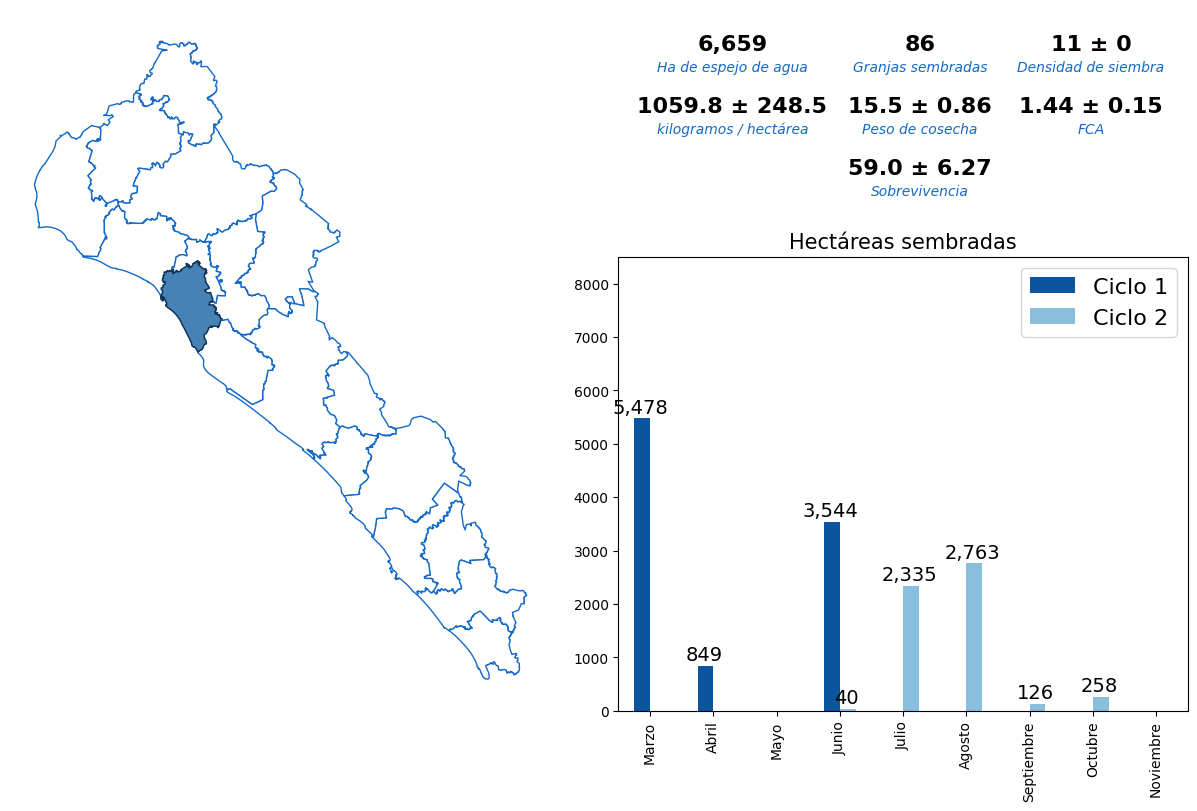

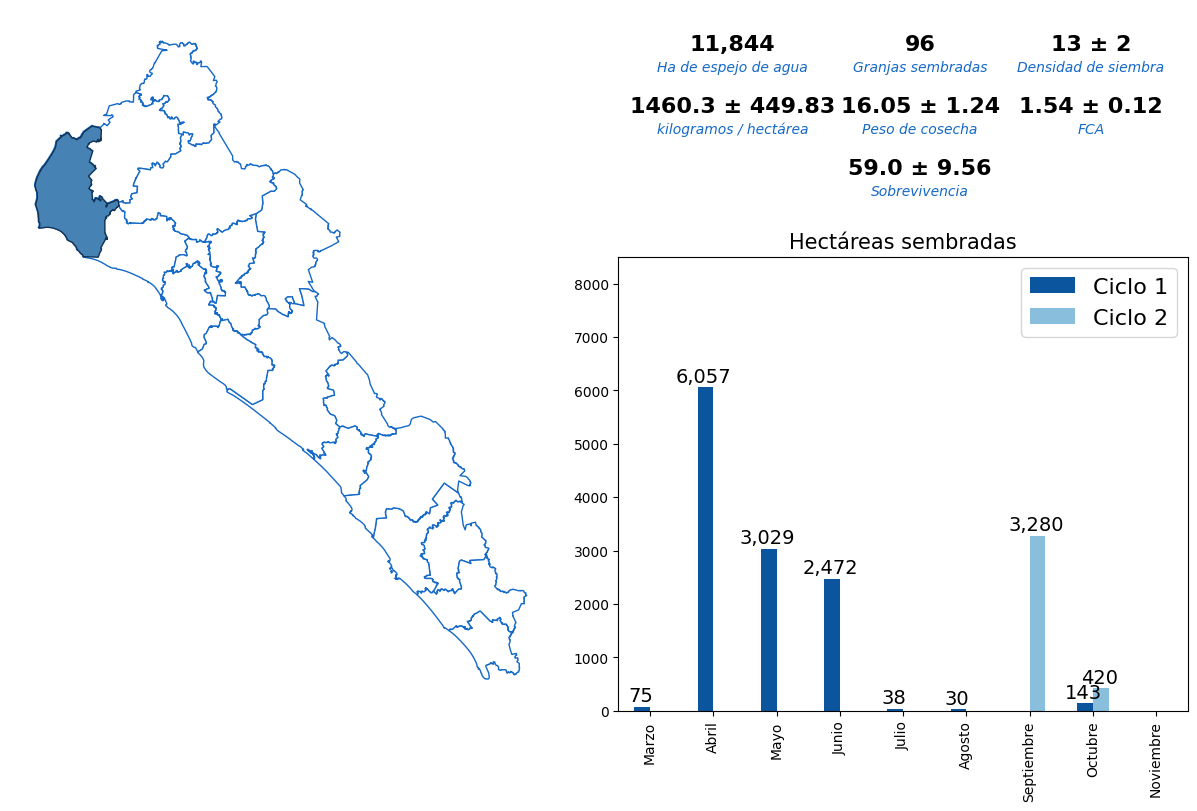

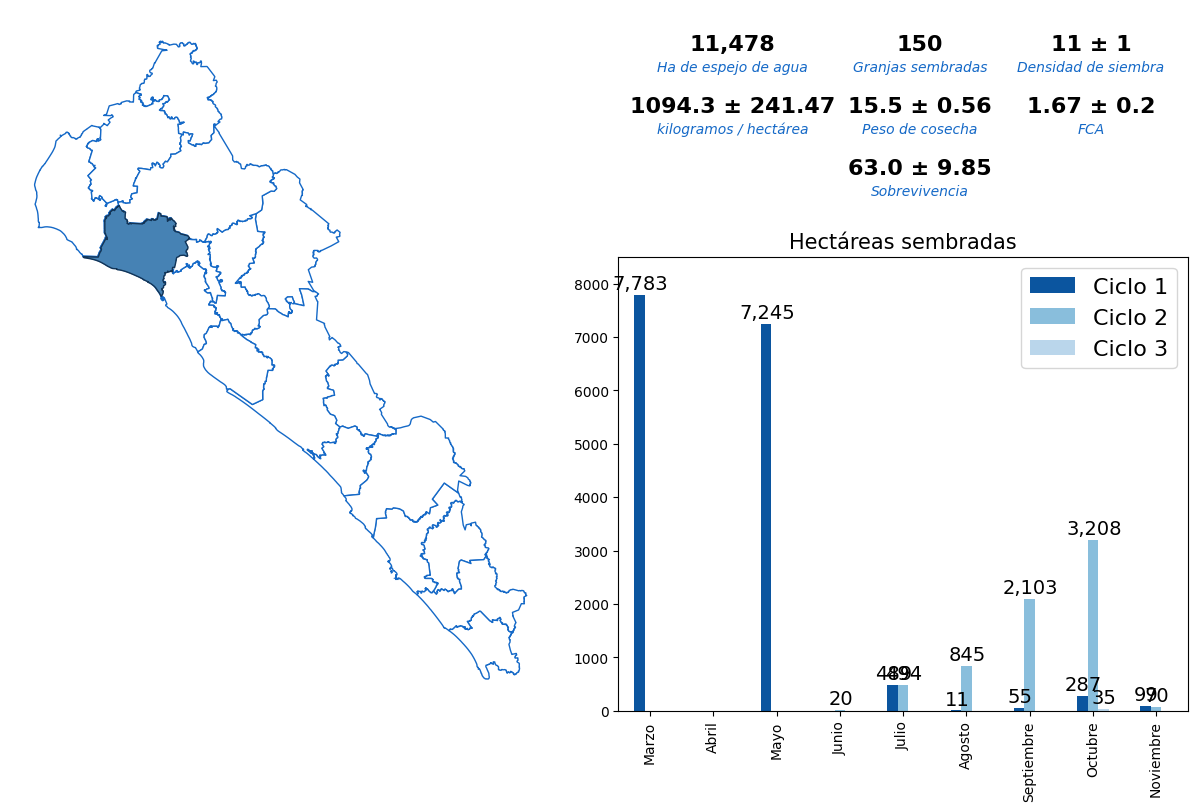

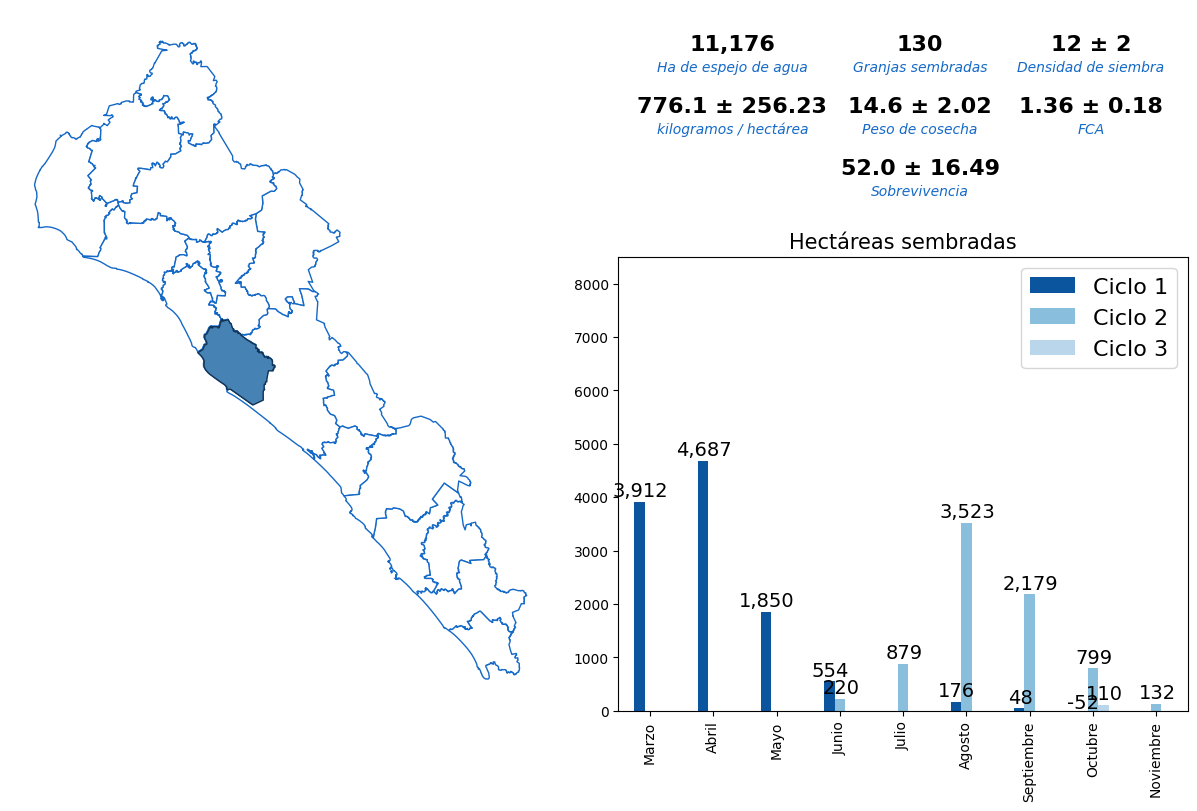

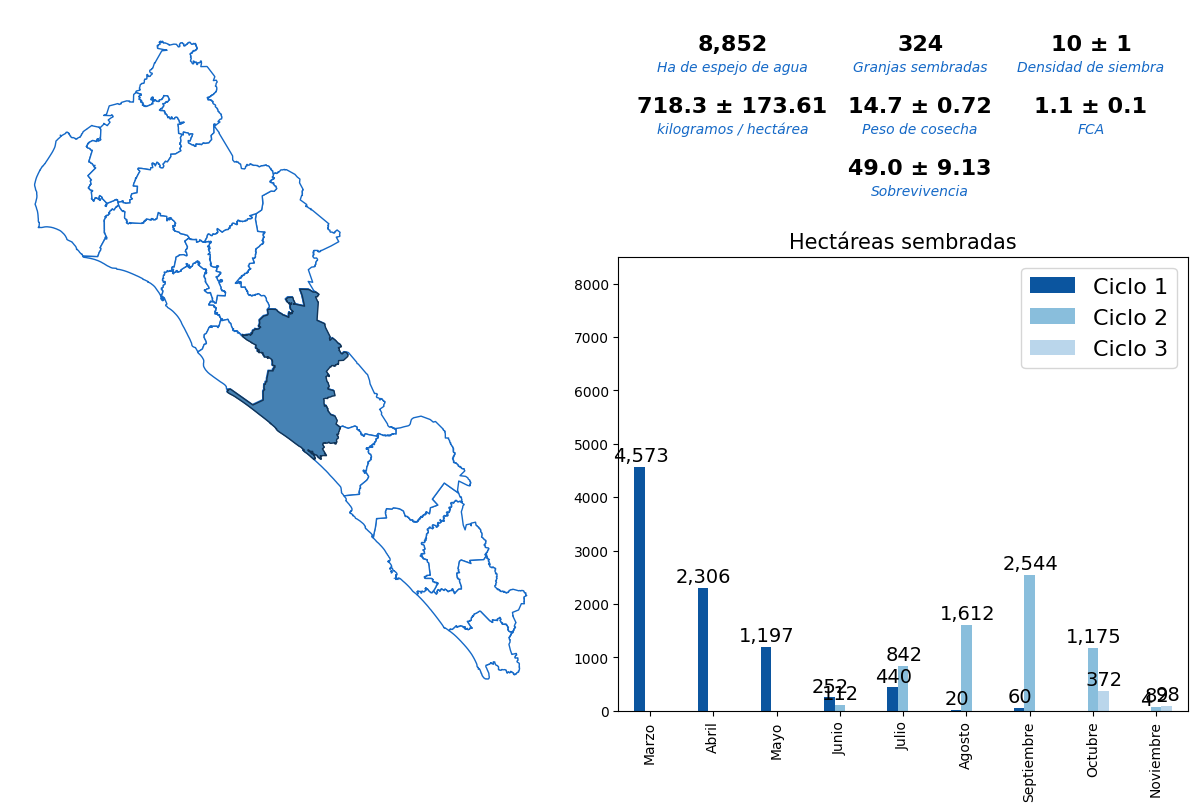

In [24]:
angostura.plots(), ahome.plots(), guasave.plots(), navolato.plots () , culiacan.plots()

__References__

Consejo Estatal de Sanidad Acuícola (23 de diciembre del 2023). Programa de Sanidad en Crustáceos. http://cesasin.mx/programacrustaceos/#produccion
